<h1>Прогноз аренды велосипедов</h1>

<p><b>Задача: </b> на основе календарной информации и погодных условий спрогнозровать спрос на аренду велосипедов (задача реграссии)</p>

In [4]:
import pandas as pd
import numpy as np

In [57]:
data = pd.read_csv("bikes_rent.csv")

In [58]:
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


<h1>0. Первичный анализ данных</h1>

In [81]:
data.shape

(731, 13)

<p>Проверим датасет на пустые значения</p>

In [143]:
data.isnull().sum()

season            0
yr                0
mnth              0
holiday           0
weekday           0
workingday        0
weathersit        0
temp              0
atemp             0
hum               0
windspeed(mph)    0
windspeed(ms)     0
cnt               0
dtype: int64

In [144]:
data.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,20.310776,23.717699,62.789406,12.762576,5.705220,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,7.505091,8.148059,14.242910,5.192357,2.321125,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,0.670650,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.820424,16.892125,52.000000,9.041650,4.041864,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,20.431653,24.336650,62.666700,12.125325,5.420351,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.872077,30.430100,73.020850,15.625371,6.984967,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,15.198937,8714.000000


<p>Признаки имеют разный масштаб, следует нормировать матрицу</p>

<h2>1. Визуальный анализ данных</h2>

<p>Для исследования зависимости между двумя признаками посторим матрицу корреляций по Пирсону</p>

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mean', 'axes', 'std']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


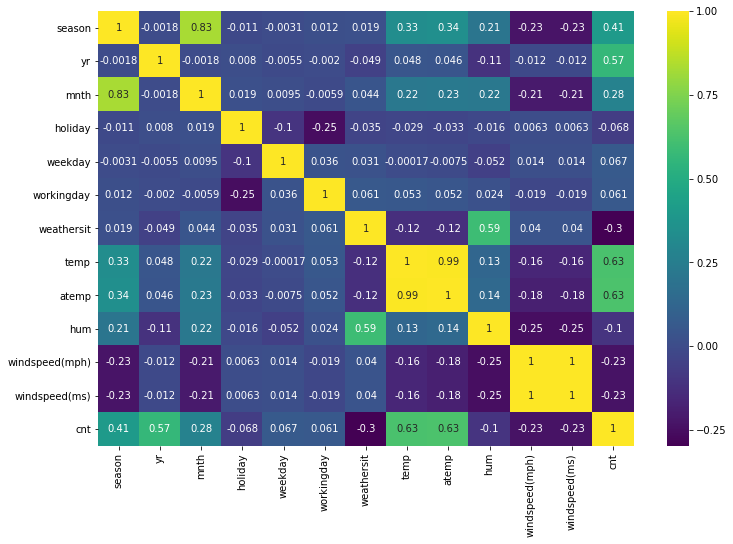

In [147]:
import seaborn as sns
%pylab inline

corr = data.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='viridis', annot=True )

<p>Наблюдается сильная корреляция признаков atemp и temp, абсолютная индеинтичность призноков windspeed. Это может сильно ухудшить модель<br>
В дальнейшем будет рассмотренно два варианта:<br> 
    1)Избавление от похожих признаков <br>
    2)Регуляризация моделей
</p>

<h2>Реализация линейной регрессии</h2>

<p>Проведем масштабирование признаков</p>

In [165]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dataset_norm = scaler.fit_transform(data)

In [167]:
X = data.drop("cnt", axis=1)
y = data["cnt"]

In [168]:
X = scaler.fit_transform(X)

<p>Добавляем столбец из единиц, для обработки коэффициента w0</p>

In [169]:
X = np.hstack((np.ones((X.shape[0], 1)), X))

In [170]:
#ф-ция определения отклонения
def mserror(y, y_pred):
    return sum((y_pred - y)**2) / len(y)

<p>Реализуем ф-цию нахождения весов w <b> согласно нормальному уравнению линейной регрессии</b></p>

In [171]:
def normal_equation(X, y):
    return (np.linalg.inv((X.T).dot(X)).dot(X.T)).dot(y)

norm_weights = normal_equation(X, y)
print(norm_weights)

[ 4.50434884e+03  5.72587430e+02  1.01060400e+03 -1.16328008e+02
 -8.21563059e+01  1.36259832e+02  5.42450060e+01 -2.55994033e+02
 -6.13864101e+02  1.60865103e+03 -2.67245100e+02  1.06814704e+05
 -1.06957144e+05]


<p>Высокие коэффициенты весов, говорят о линейной зависимости признаков -> потребуется регуляризация</p>

In [82]:
def linear_prediction(X, w):
    return X.dot(w)

In [172]:
hand_linear = mserror(y, linear_prediction(X, norm_weights))
print(hand_linear)

774125.5949618911


<p>Известно, что вычисление обратной матрицы очень ресурсоемкая операция, ее можно заменить градиентым спуском</p>

<p>Реализуем стохоастический градиентный спуск для линейной регрессии</p>

In [173]:
def stochastic_gradient_step(X, y, w, train_ind, eta=0.01):
    Xi = X[train_ind, :]
    yi = y[train_ind]
    y_pred = np.dot(Xi, w)
    l = len(y)
    return w - (2 * eta / l) * (y_pred - yi) * Xi

In [174]:
def stochastic_gradient_descent(X, y, w_init, eta=1e-2, max_iter=1e4,
                                min_weight_dist=1e-8, seed=42, verbose=False):

    weight_dist = np.inf
    w = w_init
    errors = []
    iter_num = 0
    np.random.seed(seed)
        
    while weight_dist > min_weight_dist and iter_num < max_iter:
        random_ind = np.random.randint(X.shape[0])
        errors.append(mserror(y, linear_prediction(X, w)))
        w_new = stochastic_gradient_step(X, y, w, 
                                         train_ind=random_ind,
                                         eta=eta)
        weight_dist = np.linalg.norm(w_new - w, ord=2)
        w = w_new
        iter_num += 1
        
    return w, errors

In [175]:
%%time
stoch_grad_desc_weights, stoch_errors_by_iter = stochastic_gradient_descent(X=X, 
                                                                            y=y, 
                                                                            w_init=[0, 0, 0, 0, 0, 0,
                                                                                   0, 0, 0, 0, 0 , 0 ,0],
                                                                            eta=0.01,
                                                                            max_iter=10**5)

CPU times: user 1min 43s, sys: 2min 16s, total: 4min
Wall time: 1min 6s


In [176]:
print(stoch_grad_desc_weights)

[4206.82527847  -22.39396112   56.26104527   40.15969964  -48.42242257
    6.77550423  -38.21210815   93.46082942  -15.91644973   -8.0125401
 -101.417617      6.56383562    6.56383562]


In [177]:
stoch_ans = mserror(y, linear_prediction(X, stoch_grad_desc_weights))
print(stoch_ans)

3854265.246573336


<h2>L1 и L2 регуляризация  </h2>

<p>Для борьбы с линейной зависимотью признаков будут рассмотрены два типа регуляризации</p>

In [93]:
from sklearn.linear_model import Lasso, Ridge

In [178]:
linLasso = Lasso()
linLasso.fit(X, y)
print(linLasso.coef_)

[ 0.00000000e+00  5.60241616e+02  1.01946349e+03 -1.28730627e+02
 -8.61527813e+01  1.37347894e+02  5.52123706e+01 -3.32369857e+02
  3.76363236e+02  5.76530794e+02 -1.44129155e+02 -1.97139689e+02
 -2.80497757e-08]


In [179]:
linRidge = Ridge()
linRidge.fit(X, y)
print(linRidge.coef_)

[   0.          563.06457225 1018.94837879 -131.87332028  -86.746098
  138.00511118   55.90311038 -332.3497885   386.45788919  566.34704706
 -145.0713273   -99.25944108  -99.25944115]


In [180]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))

for idx, cur_alpha in enumerate(alphas):
    linLasso = Lasso(alpha=cur_alpha)
    linLasso.fit(X, y)
    coefs_lasso[idx] = linLasso.coef_

for idx, cur_alpha in enumerate(alphas):
    linRidge = Ridge(alpha=cur_alpha)
    linRidge.fit(X, y)
    coefs_ridge[idx] = linRidge.coef_


Text(0.5,1,'Ridge')

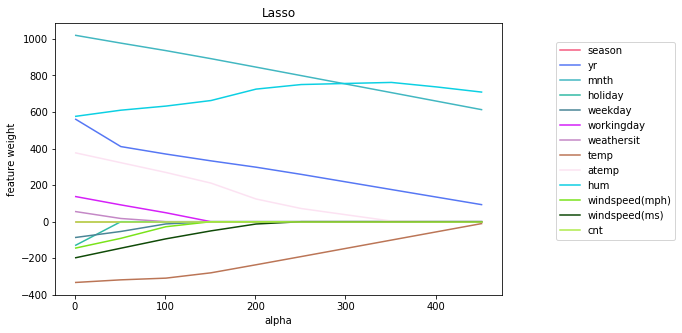

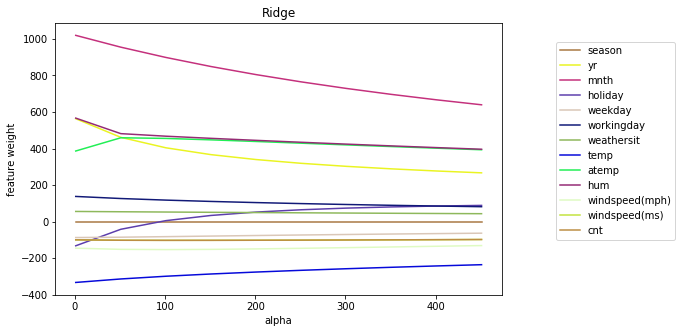

In [181]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, data.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, data.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

<p>Дальше будем использовать Lasso, блаодаря своей особенности вычисления по модулю, модель не только снижает размерность, но и зануляет "зашумляющие" признаки </p>

<p>Исследуем оптимальный параметр альфа, для логистической регресии</p>

865.5783104531832
6
[(0.0, 'season'), (532.0189828413536, 'yr'), (1015.0602226430597, 'mnth'), (-100.03952614356606, 'holiday'), (-83.29395987529935, 'weekday'), (132.50446549095778, 'workingday'), (51.55708561407365, 'weathersit'), (-330.5598567399813, 'temp'), (370.67985503003973, 'atemp'), (581.3969310654923, 'hum'), (-140.00740550068846, 'windspeed(mph)'), (-191.77140847134908, 'windspeed(ms)')]


Text(0,0.5,'MSE')

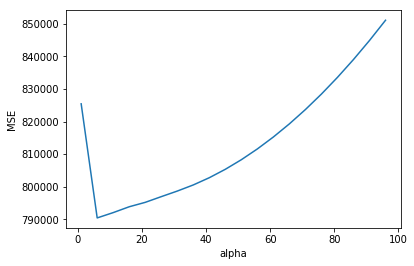

In [227]:
from sklearn.linear_model import LassoCV

new_alphas = np.arange(1, 100, 5)
lasso_cv_regressor = LassoCV(alphas=new_alphas).fit(X, y)

rmse = mean_squared_error(y, lasso_cv_regressor.predict(X)) ** 0.5
print(rmse)

print(lasso_cv_regressor.alpha_)
print( list(zip(lasso_cv_regressor.coef_, data.columns[:-1])) )

plt.plot(lasso_cv_regressor.alphas_, lasso_cv_regressor.mse_path_.mean(axis=1))
plt.xlabel('alpha')
plt.ylabel('MSE')

<h2>Random Forest</h2>

In [196]:
from sklearn import tree, ensemble, grid_search
from sklearn.cross_validation import cross_val_score
tree_clf = DecisionTreeRegressor()
tree_clf.fit(X, y)

np.mean(cross_val_score(tree_clf, X, y, scoring='mean_squared_error'))

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


-900897.8297072118

In [200]:
rf_clf = ensemble.RandomForestRegressor()
rf_clf.fit(X, y)
np.mean(cross_val_score(rf_clf, X, y, scoring='mean_squared_error'))

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


-555623.8215905462

In [201]:
parameters_grid =  {
    'n_estimators' : [5, 10, 15, 30, 50, 100, 150, 200, 300, 500],
    'max_features' : [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60],
    'max_depth' : [2, 4, 6, 8, 10, 20, 30, 50, 100],
}

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.5/dist-packages/sklearn/m

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.5/dist-packages/sklearn/m

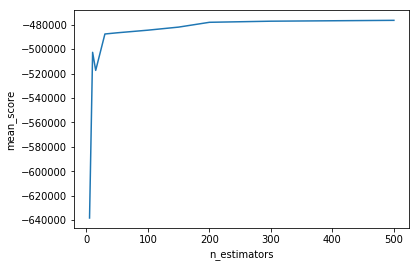

In [210]:
mean_score = []
for n_trees in parameters_grid['n_estimators']:
    scores = cross_val_score(ensemble.RandomForestRegressor(n_estimators=n_trees), X, y,
                             scoring='mean_squared_error',cv=5)
    mean_score.append(scores.mean())
    
plt.plot(parameters_grid['n_estimators'], mean_score)
plt.xlabel('n_estimators')
plt.ylabel('mean_score')
plt.show()

<h2>Градиентный бустинг</h2>

In [211]:
from sklearn import cross_validation

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, 
                                                                  test_size=0.2)

<p>Идея: создадим композицию из 50 деревьев и будем идти по антиградиенту </p>

In [228]:
def square_grad(y, y_pred):
    grad = y - y_pred
    return grad

In [229]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

estimators = []
cof = []

def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(estimators, cof)]) 
                for x in X]

n_estimators = 50
for i in range(n_estimators):
    estimator = DecisionTreeRegressor(max_depth=5, random_state=42)
    if i == 0:
        estimator.fit(X_train, y_train)
    else:
        estimator.fit(X_train, square_grad(y_train, gbm_predict(X_train)))
    estimators.append(estimator)
    cof.append(0.9)

mse = mean_squared_error(y_test, gbm_predict(X_test))
print(mse ** 0.5)

878.7316630912132


<p>Минимизируем шаг, вблизи минимума</p>

In [226]:
estimators = []
cof = []

def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(estimators, cof)]) 
                for x in X]

n_estimators = 50
for i in range(n_estimators):
    estimator = DecisionTreeRegressor(max_depth=5, random_state=42)
    if i == 0:
        estimator.fit(X_train, y_train)
    else:
        estimator.fit(X_train, square_grad(y_train, gbm_predict(X_train)))
    estimators.append(estimator)
    cof.append(0.9 / (1.0 + i))

mse = mean_squared_error(y_test, gbm_predict(X_test))
print(mse ** 0.5)

757.6437831167851


<p>Вывод: были исследованны методы, для решения задачи регрессии. Достаточно часто для решения данной задачи используют логистическую регрессию. Она легка в интерпретации признаков, имеет большую "гибкость" (можно повышать степень коэффициентов). Однако, если настроить бустинги, то можно получить даже более высокий результат</p>